In [79]:
import os
import cv2
import ray
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

from matplotlib import image as img
from scipy.spatial. distance import cosine, euclidean
from scipy.signal import convolve2d
from skimage.feature import graycomatrix
from pyfeats.textural import glcm_features, lte_measures
from sklearn.preprocessing import MinMaxScaler
from random import shuffle

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [12]:
os.listdir(PATH)

['Covid', 'Normal', 'Viral Pneumonia']

In [13]:
PATH = "train/"
files = []
classes = []
for direc in os.listdir(PATH):
    for file in os.listdir(PATH + direc):
        files.append(direc + "/" + file)
        if direc=="Covid":
            classes.append(1)
        else:
            classes.append(0)

In [3]:
def read_image(filename, width=256, height=256):
    shape = (width, height)
    return cv2.resize(
        img.imread(PATH + filename),
        shape
    )

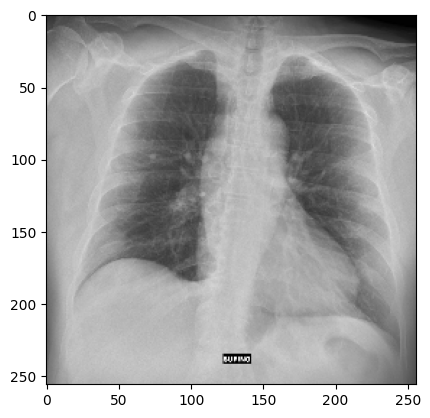

In [27]:
plt.imshow(
    read_image(files[1])
)

1


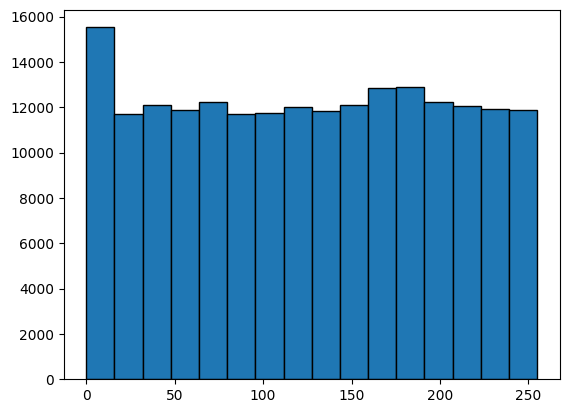

In [26]:
idx =0
plt.hist(read_image(files[idx]).ravel(), ec="k", bins=16);
print(classes[idx])

In [22]:
classes[120]

0

(array([13542., 12558., 11736., 12384., 12303., 12870., 11742., 12159.,
        11787., 12300., 12096., 11922., 12252., 11997., 12798., 12162.]),
 array([  0.    ,  15.9375,  31.875 ,  47.8125,  63.75  ,  79.6875,
         95.625 , 111.5625, 127.5   , 143.4375, 159.375 , 175.3125,
        191.25  , 207.1875, 223.125 , 239.0625, 255.    ]),
 <BarContainer object of 16 artists>)

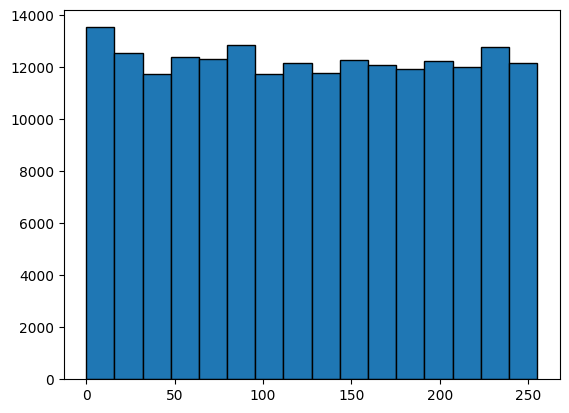

In [23]:
plt.hist(read_image(files[120]).ravel(), ec="k", bins=16)

In [29]:
L = np.array([1,4,6,4,1])
E = np.array([-1, -2, 0, 2, 1])
S = np.array([-1,0,2,0,-1])
R = np.array([1, -4, 6, -4, 1])

masks = {
    "LE": np.outer(L,E),
    "EL": np.outer(E,L),
    "LS": np.outer(L,S),
    "SL": np.outer(S, L),
    "LR": np.outer(L,R),
    "RL": np.outer(R,L),
    "ES": np.outer(E,S),
    "SE": np.outer(S,E),
    "ER": np.outer(E,R),
    "RE": np.outer(R,E),
    "SR": np.outer(S,R),
    "RS": np.outer(R,S),
    "EE": np.outer(E,E),
    "SS": np.outer(S,S),
    "RR": np.outer(R,R)
}

In [32]:
masks["LE"]

array([[ -1,  -2,   0,   2,   1],
       [ -4,  -8,   0,   8,   4],
       [ -6, -12,   0,  12,   6],
       [ -4,  -8,   0,   8,   4],
       [ -1,  -2,   0,   2,   1]])

In [30]:
def law_mask(img):
    leel = (convolve2d(img, masks["LE"]) + convolve2d(img, masks["EL"]))/2
    lssl = (convolve2d(img, masks["LS"]) + convolve2d(img, masks["SL"]))/2
    lrrl = (convolve2d(img, masks["LR"]) + convolve2d(img, masks["RL"]))/2
    esse = (convolve2d(img, masks["ES"]) + convolve2d(img, masks["SE"]))/2
    erre = (convolve2d(img, masks["ER"]) + convolve2d(img, masks["RE"]))/2
    srrs = (convolve2d(img, masks["SR"]) + convolve2d(img, masks["RS"]))/2
    ee = convolve2d(img, masks["EE"])
    ss = convolve2d(img, masks["SS"])
    rr = convolve2d(img, masks["RR"])
    
    new_shape = leel.shape + (1,)
    return np.concatenate((
        leel.reshape(new_shape),
        lssl.reshape(new_shape),
        lrrl.reshape(new_shape),
        esse.reshape(new_shape),
        erre.reshape(new_shape),
        srrs.reshape(new_shape),
        ee.reshape(new_shape),
        ss.reshape(new_shape),
        rr.reshape(new_shape)
    ), axis=2)

In [49]:
cov = law_mask(read_image(files[0]).mean(axis=2))
non_cov = law_mask(read_image(files[120]).mean(axis=2))

0.0 180.05875898270133 -3284.0 3242.0
0.0 136.69279165318423 -2935.0 2771.0


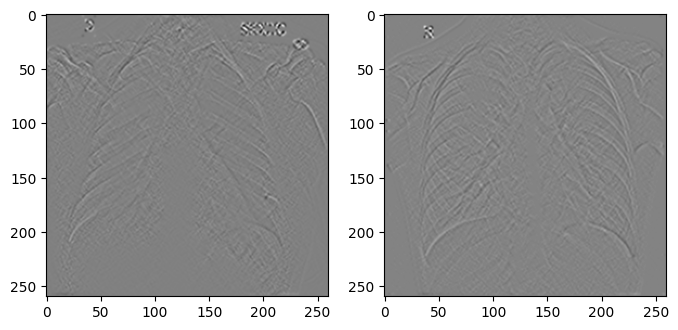

In [54]:
f, ax= plt.subplots(1,2, figsize=(8,8))
idx=6
ax[0].imshow(cov[:,:,idx], cmap="gray")
ax[1].imshow(non_cov[:,:,idx], cmap="gray")
print(cov[:,:,idx].mean(),  cov[:,:,idx].std(), cov[:,:,idx].min(),  cov[:,:,idx].max(),)
print(non_cov[:,:,idx].mean(),  non_cov[:,:,idx].std(), non_cov[:,:,idx].min(),  non_cov[:,:,idx].max(),)

In [37]:
cov.shape

(260, 260, 9)

In [58]:
images = []
for file in files:
    try:
        temp = law_mask(read_image(file).mean(axis=2))
    except:
        temp = law_mask(read_image(file))
    finally:
        images.append(temp)

In [60]:
images = np.array(images)

In [63]:
images.reshape

(251, 260, 260, 9)

In [65]:
model = SVC().fit(
    X=images.reshape(251, 260*260*9),
    y=classes
)

In [66]:
model.score(images.reshape(251, 260*260*9), classes)

1.0

In [67]:
test_files = []
test_classes = []
TEST_PATH="test/"
for direc in os.listdir(TEST_PATH):
    for file in os.listdir(TEST_PATH + direc):
        test_files.append(direc + "/" + file)
        if direc=="Covid":
            test_classes.append(1)
        else:
            test_classes.append(0)

In [70]:
PATH="test/"

In [71]:
test_images = []
for file in test_files:
    try:
        temp = law_mask(read_image(file).mean(axis=2))
    except:
        temp = law_mask(read_image(file))
    finally:
        test_images.append(temp)

In [76]:
test_images = np.array(test_images).reshape(66, 260*260*9)

In [75]:
model.score(test_images.reshape(66, 260*260*9), test_classes)

0.8939393939393939

In [78]:
preds = model.predict(test_images)

In [80]:
print(classification_report(test_classes,preds))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92        40
           1       0.91      0.81      0.86        26

    accuracy                           0.89        66
   macro avg       0.90      0.88      0.89        66
weighted avg       0.90      0.89      0.89        66



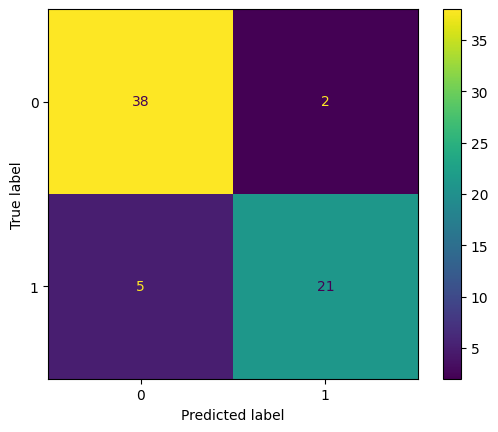

In [81]:
ConfusionMatrixDisplay(
    confusion_matrix(test_classes, preds)
).plot()

I was not expecting results so good. <br>
It seems that these texture features in the original form can get distinct information for classification purposes

Still, MxNx9 is a lot of space, we will represent each vector with a reduced feature vector and compare results

In [84]:
def get_stats(img):
    mean = img.mean()
    std = img.std()
    max_ = img.max()
    min_ = img.min()
    skew = ss.skew(img.ravel())
    kurt = ss.kurtosis(img.ravel())
    
    return np.array([mean, std, max_, min_, skew, kurt])

In [85]:
images = list(
    map(get_stats, images)
)

In [87]:
images = np.array(images)

In [88]:
images.shape

(251, 6)

In [89]:
model = SVC().fit(
    X=images,
    y=classes
)

In [90]:
model.score(images, classes)

0.6812749003984063

In [91]:
test_images = list(
    map(get_stats, test_images)
)

In [92]:
test_images = np.array(test_images)

In [93]:
model.score(test_images, test_classes)

0.7424242424242424

In [94]:
preds = model.predict(test_images)

In [95]:
print(classification_report(test_classes, preds))

              precision    recall  f1-score   support

           0       0.74      0.88      0.80        40
           1       0.74      0.54      0.62        26

    accuracy                           0.74        66
   macro avg       0.74      0.71      0.71        66
weighted avg       0.74      0.74      0.73        66



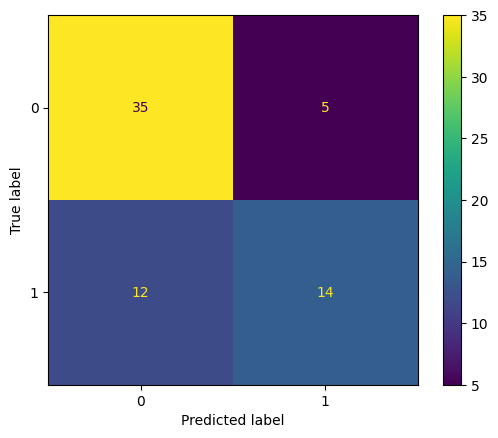

In [96]:
ConfusionMatrixDisplay(
    confusion_matrix(test_classes, preds)
).plot()

Increase in both FP and FN, with more relevance for FN. <br>
The results are not bad for a scenario in which a FN is not of a big concern (which is not the case). 